# Intertext Graph Library Tutorial

This notebook is meant as an introduction to the `intertext_graph` library. It offers classes and functions to process documents as graphs. After a short introduction to the concept behind the library, the main classes and functionalities of the library are introduced.

## Basics

The intertext_graph library builds on the notion of documents as **graphs**. Each content element of a document (e.g. its title, a paragraph, a section title, a table or a figure) is a **node** in this graph. The nodes are connected by **edges** that specify the relations between the nodes.
In the most basic version, a document graph would consist only of the content nodes and **parent** edges that specify the hierarchical relations in a document. For example, a section title node would have a `parent` edge to each of the paragraphs in that section (see image below).
In the Intertext graph framework, we consider several additional edge types: **next**, **ref** and **link** edges.
`next` edges store the chronological order of the document elements, such that there is a `next` edge between every two consecutive elements in a document (e.g. between *Title* and *Introduction* in the image below).
`ref` edges connect regular content elements (usually paragraphs) with the bibliography items they reference.
`link` edges symbolize various types of connections between document elements. They can occur between elements of the same document, e.g. when a paragraph mentions a specific figure. They can also occur between elements of different documents.

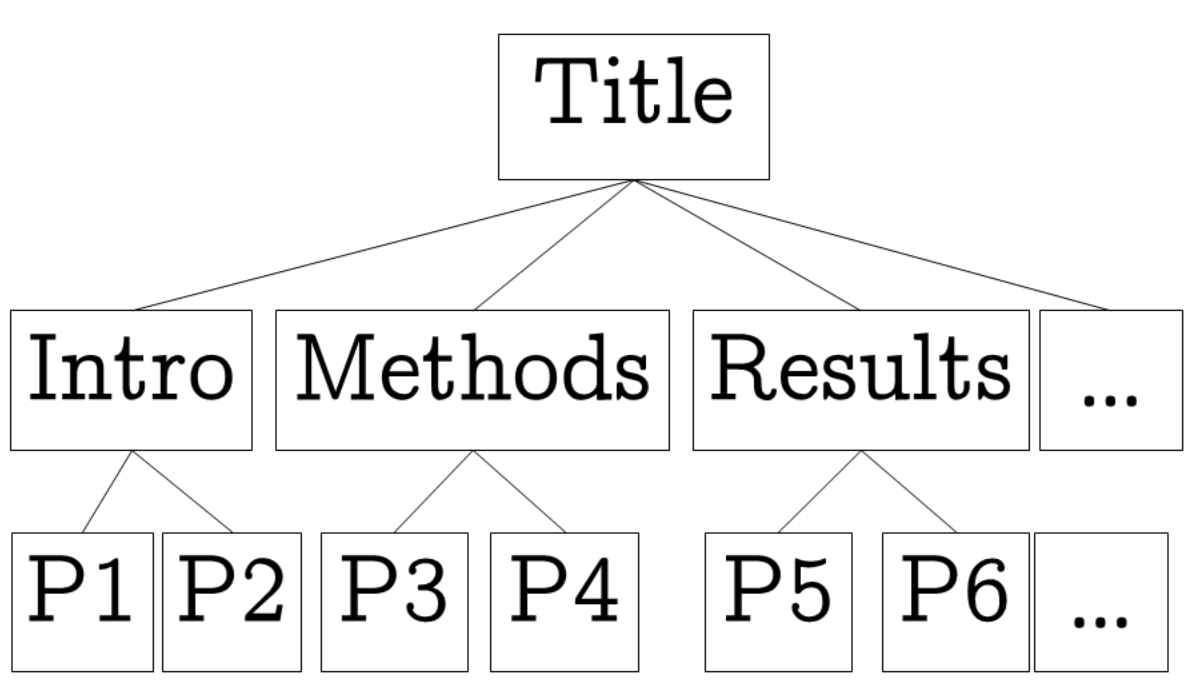

In [1]:
import os.path

from IPython.display import Image
Image('../img/simple_doc_graph.png')

## Parsing Source Files to Intertext Graphs

For a range of source file types, parsers to the intertext graph format have already been developed. They can be found in the `parsers` directory of the `intertext_graph` library.

Below, you will find an example of parsing an xml file from the open science platform F1000Research into multiple intertext graph objects.

### Parsing F1000 XML Files

In [2]:
from pathlib import Path

from intertext_graph.parsers import F1000XMLParser

# Define a path to an F1000 XML file
path = Path('../example_data/207_6-229_v1.xml')

# Get an F1000 XML parser object
parser = F1000XMLParser(path)

# Parse the xml
article, reviews, revision = parser()

The parsed output is specific to the parser used. In the F1000 case, it is a tuple of `(<article>, {<review_id>: <review>}, <revision>)`.
where
`<article>`, `<review>` and `<revision>` are `IntertextDocument` objects (also called intertext graphs or ITGs in short).

## The Basic intertext_graph objects
Let us continue with the parsed F1000 article from above to showcase some of the basic properties and functionalities of the intertext_graph data model. The main class is the `IntertextDocument` class.

In [3]:
# We take the article only
print(type(article))

<class 'intertext_graph.itgraph.IntertextDocument'>


An `IntertextDocument` object mainly consists of nodes and edges. Before coming to the properties of the `IntertextDocument`, let us have a look at its main building blocks.

## Nodes
The nodes contain the content of the underlying document. The content is usually textual (i.e. in the form of a string), but can also be a table or a figure (Properly displaying the figures in an `IntertextDocument` object is currently not implemented.

The nodes can be accessed with the `nodes` attribute

In [4]:
# Get the number of nodes in the article
print(len(article))

62


In [5]:
# Get the first node
first_node = article.nodes[0]

print(type(first_node))

<class 'intertext_graph.itgraph.Node'>


In [6]:
print(first_node)

A survey of working conditions within biomedical research in the United Kingdom


Here, we can note two things. First, printing a `node` outputs its content. Second, while here, the first node in the list of nodes actually corresponds to the beginning of the article (its title), **this must not necessarily be the case**. In general, the list of nodes can be in any order, and their relations are defined by the _edges_ between them.

### Node Attributes

Nodes have several attributes that give information about the node.

The most basic is of course its `content`, which we already saw by printing the node.

In [7]:
# To get the content, we access the content attribute
content = first_node.content

print(content)

A survey of working conditions within biomedical research in the United Kingdom


Nodes also have a type, which is given by the `ntype` attribute.
It can be any string, but typical are `article-title`, `title` (for section titles), `abstract`, `p` (for paragraphs), `figure` and `table`.

In [8]:
# Get the node type
print(first_node.ntype)

article-title


Every Node has an `ix` attribute, that uniquely identifies it, usually with a human-interpretable string.

In [9]:
# Get the node ix
print(first_node.ix)

6-229_v1_0


Nodes can have optional meta-data stored in a dictionary under the `meta` attribute. The keys are not standardized and defined by the source document and the parser.

In [10]:
# Get the metadata
print(article.nodes[6].meta)

{'section': '1', 'sec-type': 'intro', 'created_by': 'F1000XMLParser'}


### Accessing Nodes

As we already saw, we can get a node by its index from the `nodes` attribute of the `IntertextDocument` object.

In [11]:
# Get a node by its index in the list of nodes
print(article.nodes[1])

Abstract


We can also get a node by its `ix` attribute:

In [12]:
# Get a node by its ix
n = article.get_node_by_ix('6-229_v1_1')
print(n)

Abstract


## Edges

Edges define the *relations* between nodes. In the intertext_graph framework, they are directed, i.e. they have a *source* and a *target*.

In [13]:
# Get the first edge
first_edge = article.edges[0]

### Edge Attributes

Source node and target node can be accessed with the `src_node` and `tgt_node` attributes.

In [14]:
# Get the source node
source_node = first_edge.src_node

print(source_node)

A survey of working conditions within biomedical research in the United Kingdom


In [15]:
# Get the target node
target_node = first_edge.tgt_node

print(target_node)

Abstract


We can use the `etype` attribute to get the type of the edge.

In [16]:
# Get the edge type
edge_type = first_edge.etype

print(edge_type)

parent


In the intertext_graph library, edge types are implemented in a special class, the `Etype` class, which inherits from the python built-in `Enum` class. This ensures that each edge has one of the pre-defined edge types that are explained above.

In [17]:
print(type(edge_type))

<enum 'Etype'>


Creating a new `Etype` object is simple:

In [18]:
from intertext_graph import Etype
# method 1 to create a new Etype object
new_etype_1 = Etype.PARENT

# method 2
new_etype_2 = Etype['PARENT']

As with the nodes, each `edge` object has a unique `ix` attribute.

In [19]:
# Get the edge ix
edge_ix = first_edge.ix

print(edge_ix)

6-229_v1_0_6-229_v1_1_parent


And again, edges have optional, non-standardized metadata in dict format.

In [20]:
# Get the metadata (in this case there is no metadata)
edge_meta = first_edge.meta

print(edge_meta)

{'created_by': 'F1000XMLParser'}


## Combining Nodes and Edges

### Outgoing and Incoming Edges

Each node has an `incoming_edges` and an `outgoing_edges` attribute. It gives convenient access to the edges that target the node (incoming) and the edges have their source in the node (outgoing).

In [21]:
# Get the outgoing edges of the first node
outgoing_edges = first_node.outgoing_edges

# Print the content of the target nodes end the edge type
for e in outgoing_edges:
    print(e.etype)
    print(e.tgt_node)

parent
Abstract
parent
Introduction
parent
Methods
parent
Results
parent
Discussion
parent
Ethics statement
parent
Data availability
next
Abstract


## The IntertextDocument Object

An `IntertextDocument` object stores the underlying document in a graph representation. We have already seen how to access nodes and edges.

### IntertextDocument Attributes
Similar to nodes and edges, an `IntertextDocument` object has meta-data in a dictionary. As before, this metadata is not standardized, but typically contains a key `doc_id` that is meant to uniquely identify the document.

In [22]:
# Get the article metadata
article_meta = article.meta

print(article_meta)

{'parser': 'F1000XMLParser', 'intertext-graph': '0.5', 'doi': '10.12688/f1000research.11029.1', 'atype': 'research-article', 'license': 'http://creativecommons.org/licenses/by/4.0/', 'title': 'A survey of working conditions within biomedical research in the United Kingdom', 'abstract': 'Background: Many recent articles have presented a bleak view of career prospects in biomedical research in the US. Too many PhDs and postdocs are trained for too few research positions, creating a “holding-tank” of experienced senior postdocs who are unable to get a permanent position. Coupled with relatively low salaries and the high levels of pressure to publish in top-tier academic journals, this has created a toxic environment that is perhaps responsible for a recently observed decline in biomedical postdocs in the US, the so-called “postdocalypse”. Methods: In order to address the gulf of information relating to working habits and attitudes of UK-based biomedical researchers, a survey was conducted

An `IntertextDocument` object also has a `root` attribute that specifies the *first* or *root* node in the graph, usually the document title.

In [23]:
# Get the root
root = article.root

print(root)

A survey of working conditions within biomedical research in the United Kingdom


### IntertextDocument Methods

#### Serialization (Loading and Saving)

To save an `IntertextDocument` object to a file, it is serialized to a `json` object and then written out. This can be done by using the `save_json` method. It takes a file IO object as the single parameter.

In [24]:
from pathlib import Path

# Define the out file path
out_dir_path = Path('../out')
if not out_dir_path.exists():
    out_dir_path.mkdir()
out_path = out_dir_path / f'{article.meta["doc_id"]}.json'

with out_path.open('w') as file:
    article.save_json(file)


To load an `IntertextDocument` object from file, use the `load_json` method. It takes a file IO object as the single parameter.

In [25]:
from pathlib import Path

from intertext_graph import IntertextDocument

path = Path('../example_data/anarchism_wiki.json')
with path.open() as file:
    wiki_article = IntertextDocument.load_json(file)

#### Iterating over the document in sequential order

To go over the elements of a document in their original order, use the `unroll_graph` method.

In [26]:
# print the first five document elements
for n in article.unroll_graph()[:5]:
    print(n)

A survey of working conditions within biomedical research in the United Kingdom
Abstract
Background: Many recent articles have presented a bleak view of career prospects in biomedical research in the US. Too many PhDs and postdocs are trained for too few research positions, creating a “holding-tank” of experienced senior postdocs who are unable to get a permanent position. Coupled with relatively low salaries and the high levels of pressure to publish in top-tier academic journals, this has created a toxic environment that is perhaps responsible for a recently observed decline in biomedical postdocs in the US, the so-called “postdocalypse”.
Methods: In order to address the gulf of information relating to working habits and attitudes of UK-based biomedical researchers, a survey was conducted and analysed to examine discrete profiles for three major career stages: the PhD, the postdoc and the principal investigator.
Results: Overall, the data presented here echoes trends observed in the 

### Following Parent Edges to the Root

To see where a node is placed in the document hierarchy, use the `breadcrumbs` method. It follows the edges of a certain type.

In [27]:
from intertext_graph import Etype

for n in article.breadcrumbs(article.nodes[11], Etype.PARENT):
    print(n)

A ten-question survey was designed to formally evaluate the working habits of biomedical researches. While the primary intention was to gather information relating to UK-based biomedical scientists, the survey was also open to non-UK-based scientists from a broad range of backgrounds for comparison. The first three questions “what position are you?”, “broadly, what discipline do you work in?” and “what country do you work in?” aimed to serve as a filter to ensure the accurate analysis of UK-based biomedical scientists at different stages of their career. The following three questions “how many countries have you worked in over the past five years?”, “how old are you?” and “how long have you held this level of position?” aimed to construct a demographic census of the respondents, and to enable comparison between specific age groups. The next three questions focussed on the conditions scientists work under, asking “how many hours did you work last week?”, “how many days did you work last

### Creating a New IntertextDocument Object

Let us start by creating some nodes. Note that we do not yet define the `ix` attribute, as this happens automatically  when we add them to an `IntertextDocument` object.

In [28]:
from intertext_graph import Node
# Create a title node
# Write a title
title_text = 'Attention is All You Need'
# Define the node type
title_ntype = 'article-title'
# Create the node (the ntype and meta arguments are optional)
title_node = Node(
    title_text,
    ntype=title_ntype
)

# Create an abstract node
# Write the text
abstract_text = 'This paper is about attention.'
# Define the node type
abstract_ntype = 'abstract'
# Create the node
abstract_node = Node(
    abstract_text,
    ntype=abstract_ntype
)

Having created two nodes, we can now create edges between them:

In [29]:
from intertext_graph import Edge, Etype
# Create a parent edge
parent_edge = Edge(
    title_node,
    abstract_node,
    Etype.PARENT
)

# Create a next edge
next_edge = Edge(
    title_node,
    abstract_node,
    Etype.NEXT
)

We can now create a new `IntertextDocument` object. Note that besides passing the nodes and edges, we also need to pass the `prefix` argument, which is used to name nodes and edges, i.e. setting the `ix` attribute.

In [30]:
# Create an empty IntertextDocument
from intertext_graph import IntertextDocument
# Make lists of nodes and edges
nodes = [title_node, abstract_node]
edges = [parent_edge, next_edge]
# Define a prefix used in naming nodes and edges (setting the ix attribute)
prefix = 'new_itg'
new_itg = IntertextDocument(
    nodes,
    edges,
    prefix
)

To see if it worked, let us print the content of our document. We use the `unroll_graph` method we already saw.

In [31]:
for node in new_itg.unroll_graph():
    print(node)

Attention is All You Need
This paper is about attention.


As mentioned before, our nodes and edges now have the `ix` attribute set:

In [32]:
print(new_itg.nodes[0].ix)

new_itg_0


### Adding Nodes and Edges

Let's see how to add nodes and edges to an existing `IntertextDocument` object. First, we create a `Node` object.

In [33]:
from intertext_graph import Node
# Create a new node
text_to_add = 'Introduction'

ntype_to_add = 'title'

node_to_add = Node(
    text_to_add,
    ntype_to_add
)

Now we can add the new `Node` to the graph:

In [34]:
new_itg.add_node(node_to_add)

To confirm that it worked, we can check the number of nodes in the graph:

In [35]:
print(len(new_itg.nodes))

3


However, the new node is still lonely, as it is not connected to the other nodes in the graph. We create new `Edge` objects to change this. As it is a new section heading, we want it to be a child of the article title, and to follow immediately after the abstract.
Note that when creating the `parent` edge, we refer to the original `title_node` object we created before creating the `new_itg` object, while when creating the `next` edge we refer to the node in the `nodes` attribute of the `new_itg`. This shows that when adding nodes or edges to a graph, the original `Node` or `Edge` object is not copied, but still refers to the same memory location.

In [36]:
from intertext_graph import Edge, Etype
# Make the new parent edge
parent_edge_to_add = Edge(
    title_node,
    node_to_add,
    Etype.PARENT
)

# Make the new next egde
next_edge_to_add = Edge(
    new_itg.nodes[1],
    node_to_add,
    Etype.NEXT
)

# Add the edges to the graph
new_itg.add_edge(
    parent_edge_to_add
)

new_itg.add_edge(
    next_edge_to_add
)

We can confirm that it worked by printing the content of the `IntertextDocument`

In [37]:
for n in new_itg.unroll_graph():
    print(n)

Attention is All You Need
This paper is about attention.
Introduction


### Span Nodes and Span Edges

The `SpanNode` class inherits from its `intertext_graph` parent, the `Node`. The `SpanNode` class is introduced as an additional type of node to distinguish it from nodes that are defined by the source document structure (e.g. paragraphs). It has two primary use cases:
1. When we want to add additional information to the graph (e.g. class labels)
2. When we want to work at a finer granularity than provided by the document structure.

#### Use Case 1

For use case 1, let us say that we have a graph (an `IntertextDocument` object), and an annotator has labeled some of the nodes in the graph. We do not want to mess up the original graph, because we want it to only contain the information that was present in the underlying document. Therefore, we add `SpanNode` objects that refer to the regular nodes.

We first load a new graph:

In [38]:
from pathlib import Path

from intertext_graph import IntertextDocument

path = Path('../example_data/anarchism_wiki.json')
with path.open() as file:
    anarchism_itg = IntertextDocument.load_json(file)

The loaded graph is a wikipedia article on anarchism. Some cleaning of wikipedia markup was applied to it, but when printing the first 5 nodes, we see that some of it remains:

In [39]:
for i, n in enumerate(anarchism_itg.unroll_graph()[:5]):
    print(i, n.ix, n)

0 12_v1043786187_0 Anarchism
1 12_v1043786187_1 {{short description|Political philosophy and movement}}
{{redirect2|Anarchist|Anarchists|other uses|Anarchists (disambiguation)}}
{{pp-semi-indef}}
{{good article}}
{{use British English|date=August 2021}}
{{use dmy dates|date=August 2021}}
{{anarchism sidebar}}
{{basic forms of government}}
'''Anarchism''' is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be undesirable, unnecessary, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.
2 12_v1043786187_2 The history of anarchism goes back to prehistory, when humans lived in anarchic societies 

We want to label the nodes where cleaning was successful. These are the nodes at indices 2 and 4 in the printout, corresponding to `ix` `"12_v1043786187_2"` and `"12_v1043786187_4"` . We add a span node to each of these to add the label.

The arguments needed to create a `SpanNode` object are
- `ntype`, which is similar to the `ntype` of the regular `Node`
- `src_node`, which specifies the regular `Node` the `SpanNode` refers to

Optional arguments are
- `start`, which is the index of the first character of the span (default is 0)
- `end`, the index of the last character of the span (default is None), when it is not passed, the `end` attribute of the SpanNode is set to the final character of the `src_node`
- `meta`, which is similar to the `meta` argument of the regular `Node` class and can be any `dict`
- `label`, which is also a dict

Since we want to add a label to the full node, we do not need to set start, end and meta.

In [40]:
from intertext_graph import SpanNode
# We set the ntype as "s" for "span"
span_ntype = 's'

# Create the first span node
# Get the source node
src_node_1 = anarchism_itg.get_node_by_ix('12_v1043786187_2')
# Create the label
label_1 = {'clean': True}
span_node_1 = SpanNode(
    span_ntype,
    src_node_1,
    label=label_1
)

# Create the second span node
src_node_2 = anarchism_itg.get_node_by_ix('12_v1043786187_4')
# Reuse the label
label_2 = label_1
span_node_2 = SpanNode(
    span_ntype,
    src_node_2,
    label=label_2
)

The `content` attribute of a `SpanNode` object is defined as the content of its span in the source node:

In [41]:
print(span_node_1.content)

The history of anarchism goes back to prehistory, when humans lived in anarchic societies long before the establishment of formal states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose, but it was not until the 19th century that a self-conscious political movement emerged. During the latter half of the 19th and the first decades of the 20th century, the anarchist movement flourished in most parts of the world and had a significant role in workers' struggles for emancipation. Various anarchist schools of thought formed during this period. Anarchists have taken part in several revolutions, most notably in the Spanish Civil War, whose end marked the end of the classical era of anarchism. In the last decades of the 20th and into the 21st century, the anarchist movement has been resurgent once more.


While the span nodes "know" that they belong to their source node, this is not true the other way around. Therefore, we also need edges connecting the span nodes with their source. Luckily, this is handled automatically when adding a span node to an `IntertextDocument` object. Source node and span node are connected with a `link` edge.

We can now add our span nodes to the graph. Note that we add them just like we would add regular nodes.

In [42]:
anarchism_itg.add_node(span_node_1)
anarchism_itg.add_node(span_node_2)

#### Use Case 2

Let us now consider use case 2. If the finest granularity of a document layout is paragraphs, but we want to work at the sentence level, we can be consistent with the original document and create regular `Node` objects for each paragraph. Then, we can split the sentences in each paragraph and create a `SpanNode` for each sentence. `SpanNode` objects can only exist in relation to a regular `Node` object, and are defined over a *span* of that *source node*. The span is specified by the character start and end indices in the `content` attribute of the source node the `SpanNode` refers to.

Let us be more clear through an example:

The node at index 2 from above has no wikipedia markup, so we use it as an example for sentence splitting. We use its `ix` to get it.

In [43]:
node_to_split = anarchism_itg.get_node_by_ix('12_v1043786187_2')

We want to split the content of the node into sentences and get the character offsets for each sentence. We keep it simple and split at full stops.

In [44]:
# Split the node content
split_content = node_to_split.content.split('. ')
# We add back the delimiters (not very elegant)
sentences = [
    split_content[i] + ('. ' if i + 1 < len(split_content) else '') # We want to keep the delimiters
    for i in range(len(split_content))
]

# Get the character offsets for each sentence
offsets = []
idx = 0
for sent in sentences:
    offset = (idx, idx + len(sent) -1)
    idx += len(sent)
    offsets.append(offset)

Now, we can create the span nodes for the sentences and add them to the graph. This time, we pass the `start` and `end` arguments, but do not pass the label argument. Of course, we could also combine both to label spans of a node.

In [45]:
from intertext_graph import SpanNode
span_ntype = 's'
for offset in offsets:
    # Create the span node
    span_node = SpanNode(
        span_ntype,
        node_to_split,
        start=offset[0],
        end=offset[1]
    )
    # Print the span_node content
    print(span_node)
    # Add it to the graph
    anarchism_itg.add_node(span_node)

The history of anarchism goes back to prehistory, when humans lived in anarchic societies long before the establishment of formal states, realms, or empires. 
With the rise of organised hierarchical bodies, scepticism toward authority also rose, but it was not until the 19th century that a self-conscious political movement emerged. 
During the latter half of the 19th and the first decades of the 20th century, the anarchist movement flourished in most parts of the world and had a significant role in workers' struggles for emancipation. 
Various anarchist schools of thought formed during this period. 
Anarchists have taken part in several revolutions, most notably in the Spanish Civil War, whose end marked the end of the classical era of anarchism. 
In the last decades of the 20th and into the 21st century, the anarchist movement has been resurgent once more.


By printing each span node, we see that its `content` attribute mirrors its span in the source node.